In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
df = pd.read_csv('/kaggle/input/adult-income-dataset/adult.csv')
if len(df.head()) > 0:
    print('DataFrame loaded successfully.')
print(f'DataFrame contains {df.shape[0]} rows and {df.shape[1]} columns.')

DataFrame loaded successfully.
DataFrame contains 48842 rows and 15 columns.


## A little preprocessing

In [3]:
df['income'].replace(['<=50K', '>50K'], [0, 1], inplace=True)
df.replace('?', np.NaN, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [5]:
df.dropna(inplace=True)

In [6]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017,0.247844
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508,0.431766
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


## EDA

## Target (Income)

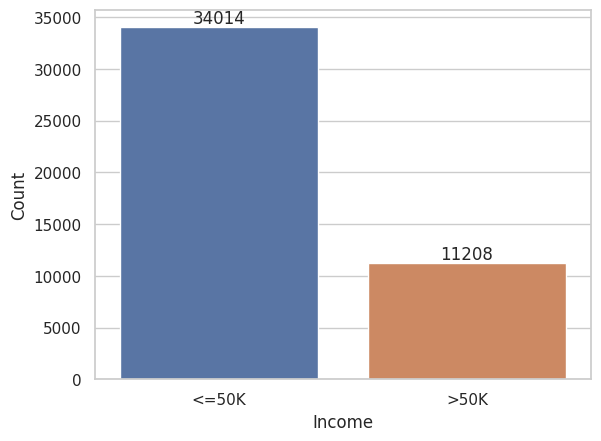

In [7]:
ax = sns.countplot(data=df, x='income');
ax.set_xticklabels(['<=50K', '>50K']);
ax.set_xlabel('Income');
ax.set_ylabel('Count');
ax.bar_label(ax.containers[0]);

In [8]:
income_less_than_50k = df.loc[df.income == 0]
income_more_than_50k = df.loc[df.income == 1]

## Age -> Income Dependency

The age of an individual

● Integer greater than 0

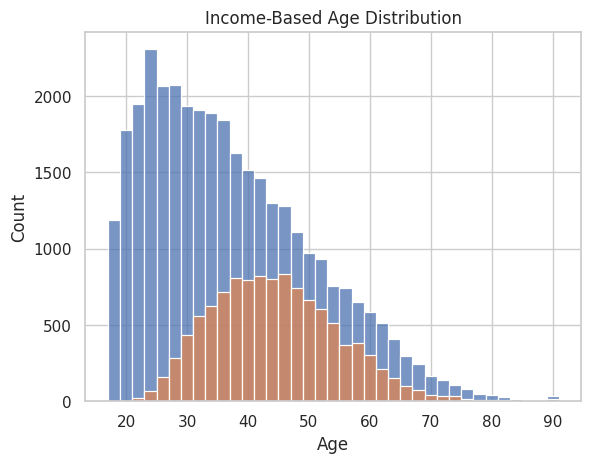

In [9]:
ax = sns.histplot(data=income_less_than_50k, x='age', binwidth=2);
ax = sns.histplot(data=income_more_than_50k, x='age', binwidth=2);
ax.set_xlabel('Age');
ax.set_title('Income-Based Age Distribution');

## Workclass -> Income Dependency

A general term to represent the employment status of an individual

● Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov,
Without-pay, Never-worked.


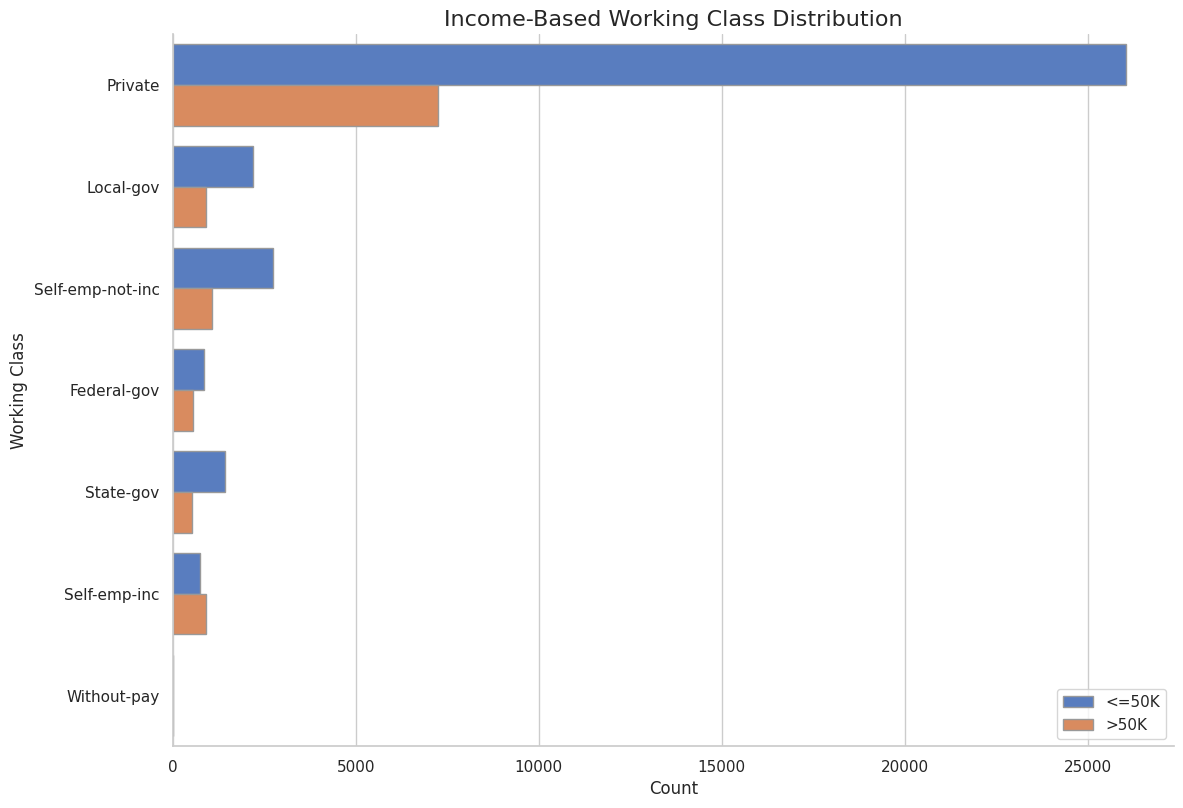

In [10]:
plot = sns.catplot(data=df, y="workclass", hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=8, aspect=1.5);
plot.set_xlabels('Count', fontsize=12);
plot.set_ylabels('Working Class', fontsize=12);
plt.legend(loc='lower right', labels=['<=50K', '>50K']);
plt.title('Income-Based Working Class Distribution', fontsize=16);

## Weights -> Income Dependency

Final weight. In other words, this is the number of people the census believes
the entry represents.

● Integer greater than 0

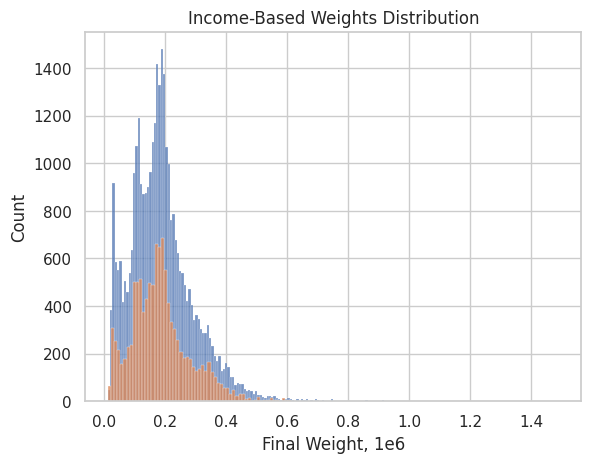

In [11]:
ax = sns.histplot(data=df, x=income_less_than_50k['fnlwgt'].apply(lambda x: x / 1e6),
                  );
ax = sns.histplot(data=df, x=income_more_than_50k['fnlwgt'].apply(lambda x: x / 1e6),
                  );
ax.set_xlabel('Final Weight, 1e6');
ax.set_title('Income-Based Weights Distribution');

## Education -> Income Dependency

The highest level of education achieved by an individual.
 
● Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc,
9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

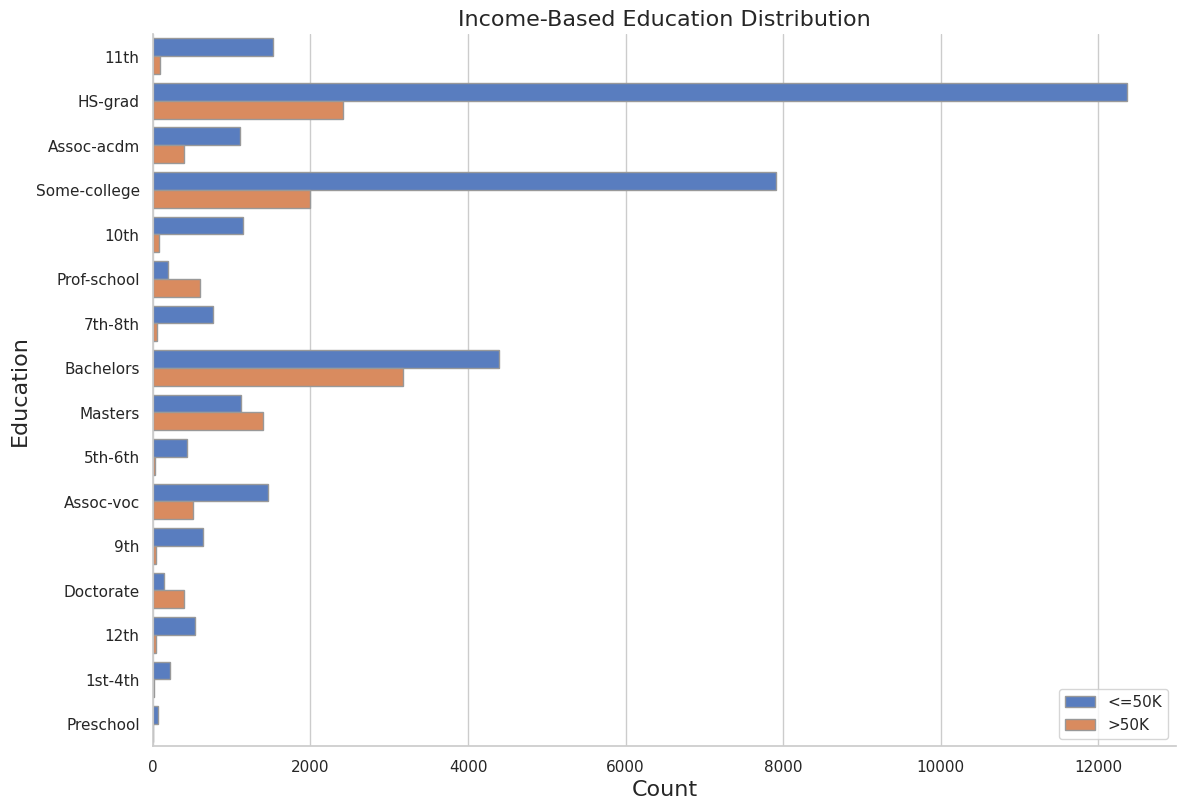

In [12]:
plot = sns.catplot(data=df, y="education", hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=8, aspect=1.5);
plot.set_xlabels('Count', fontsize=16);
plot.set_ylabels('Education', fontsize=16);
plt.legend(loc='lower right', labels=['<=50K', '>50K']);
plt.title('Income-Based Education Distribution', fontsize=16);

## Education-num -> Income Dependency

The highest level of education achieved in numerical form.

●Integer greater than 0

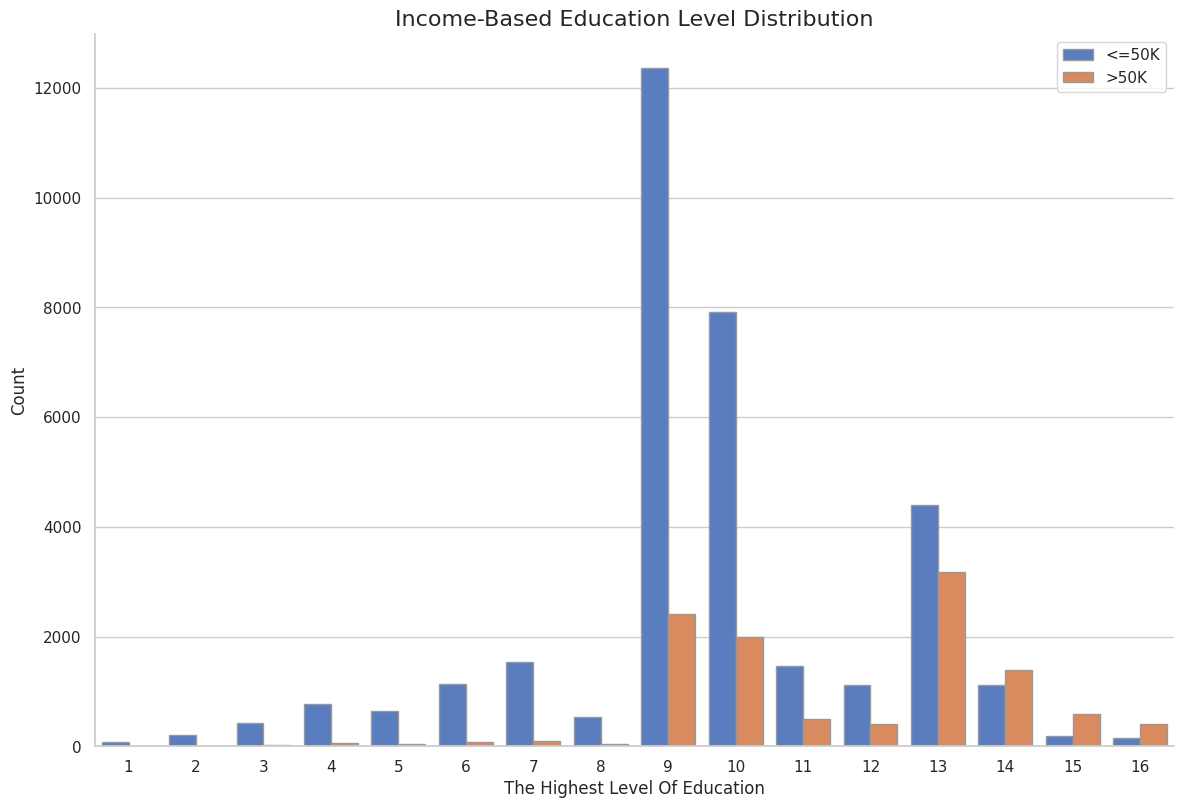

In [13]:
plot = sns.catplot(data=df, x='educational-num', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=8, aspect=1.5, orient='h');
plot.set_xlabels('The Highest Level Of Education', fontsize=12);
plot.set_ylabels('Count', fontsize=12);
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Education Level Distribution', fontsize=16);

## Marital Status -> Income Dependency

Marital status of an individual. Married-civ-spouse corresponds to a
civilian spouse while Married-AF-spouse is a spouse in the Armed Forces.

● Married-civ-spouse, Divorced, Never-married, Separated, Widowed,
Married-spouse-absent, Married-AF-spouse.


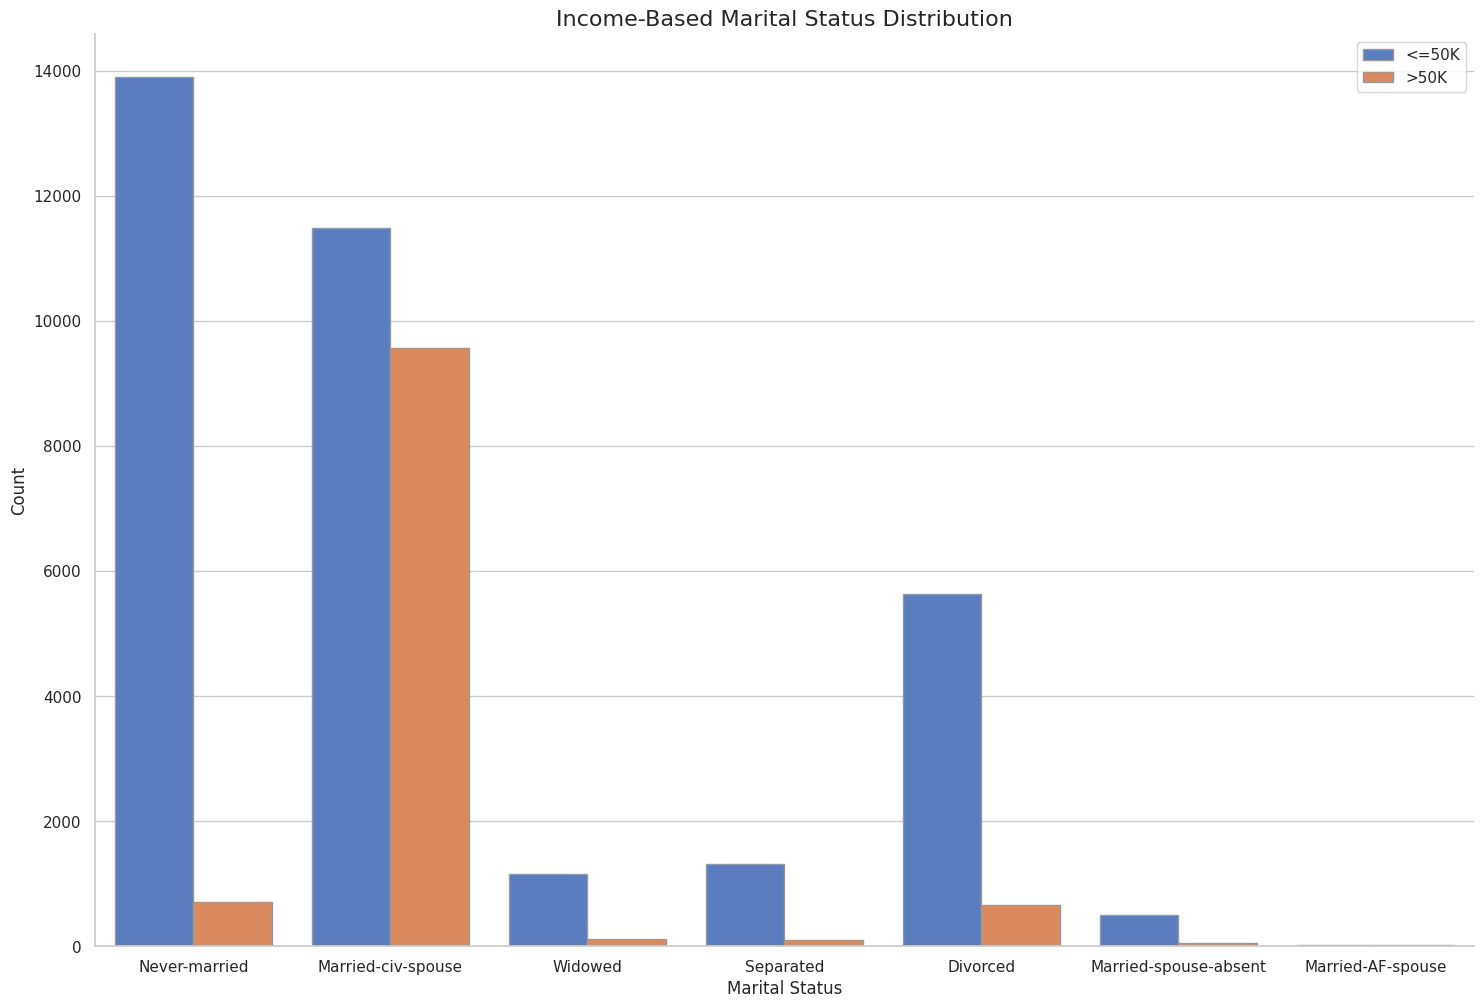

In [14]:
plot = sns.catplot(data=df, x='marital-status', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=10, aspect=1.5, orient='h');
plot.set_xlabels('Marital Status');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Marital Status Distribution', fontsize=16);

## Occupation -> Income Dependency

The general type of occupation of an individual

● Tech-support, Craft-repair, Other-service, Sales, Exec-managerial,
Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical,
Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv,
Armed-Forces.


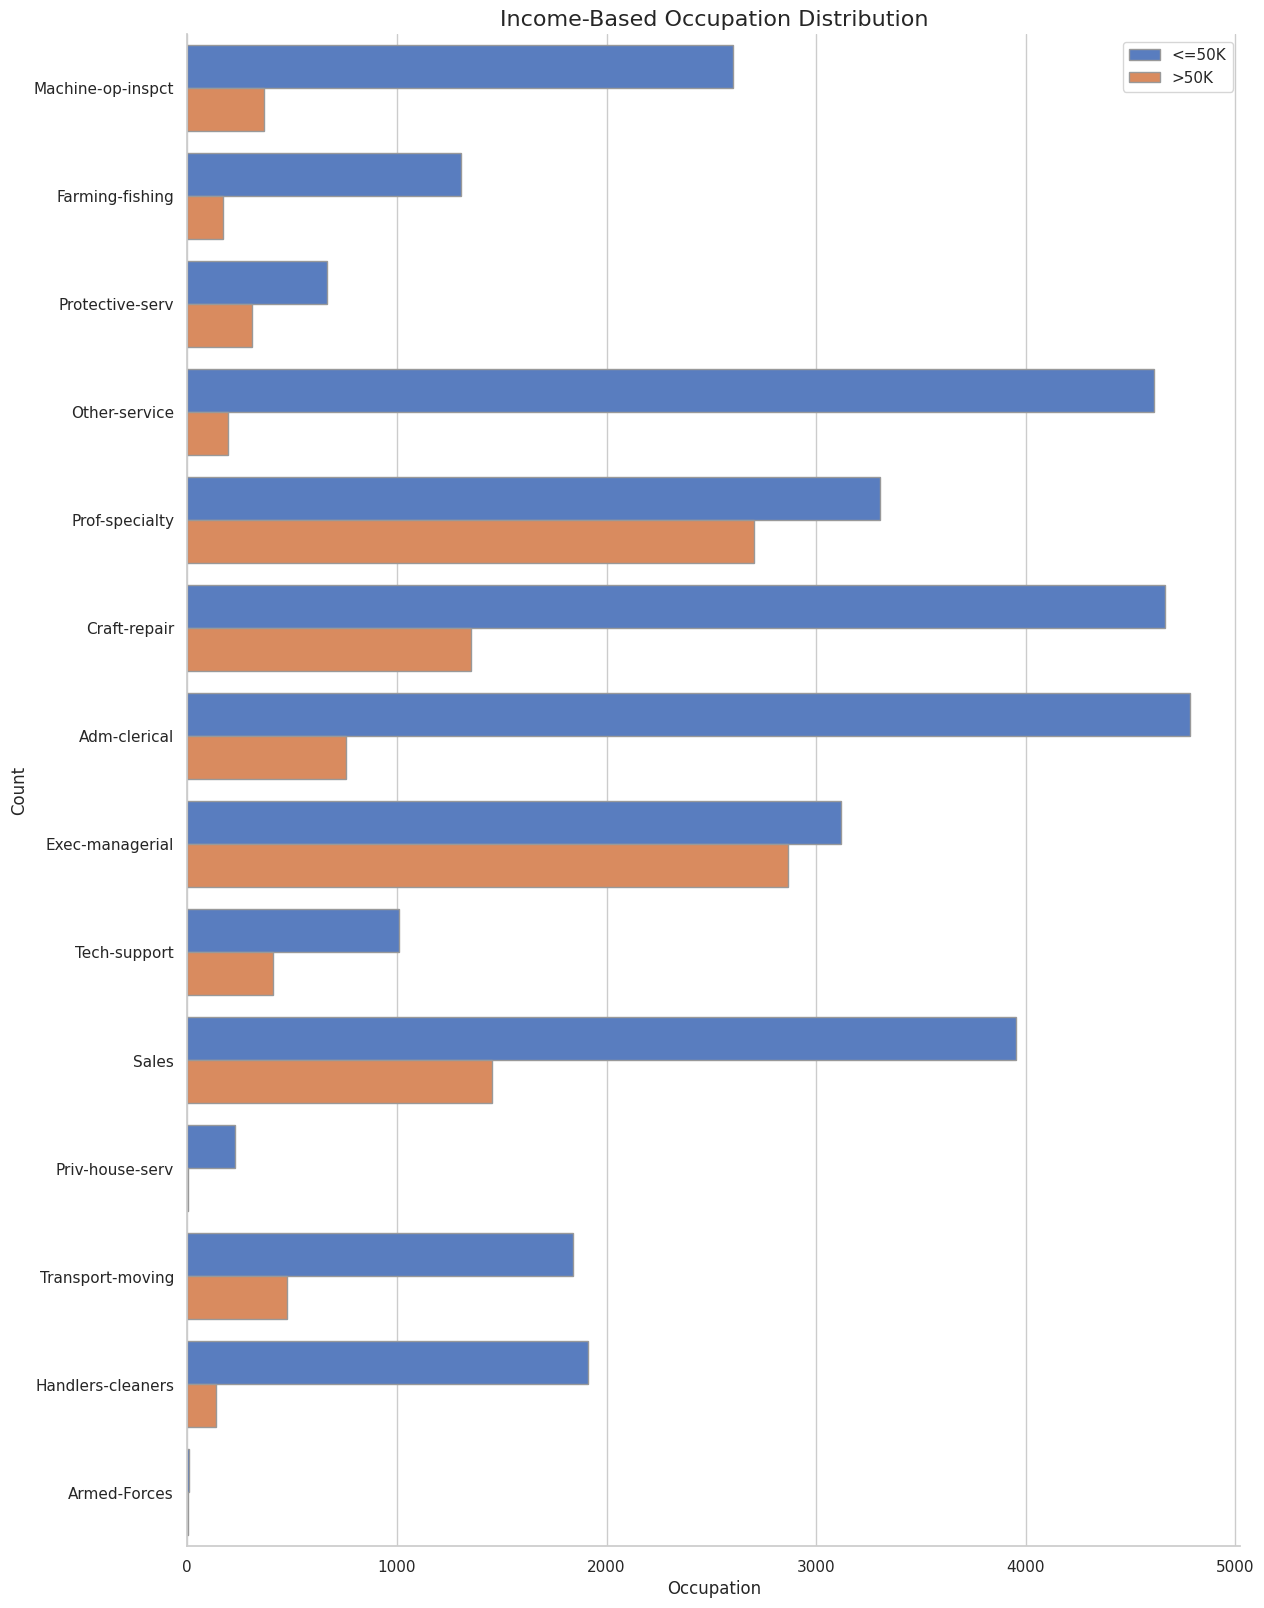

In [15]:
plot = sns.catplot(data=df, y='occupation', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=16, aspect=.8, orient='v');
plot.set_xlabels('Occupation');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Occupation Distribution', fontsize=16);

## Relationship -> Income Dependency

Represents what this individual is relative to others. For example an
individual could be a Husband. Each entry only has one relationship attribute and is
somewhat redundant with marital status.

● Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.



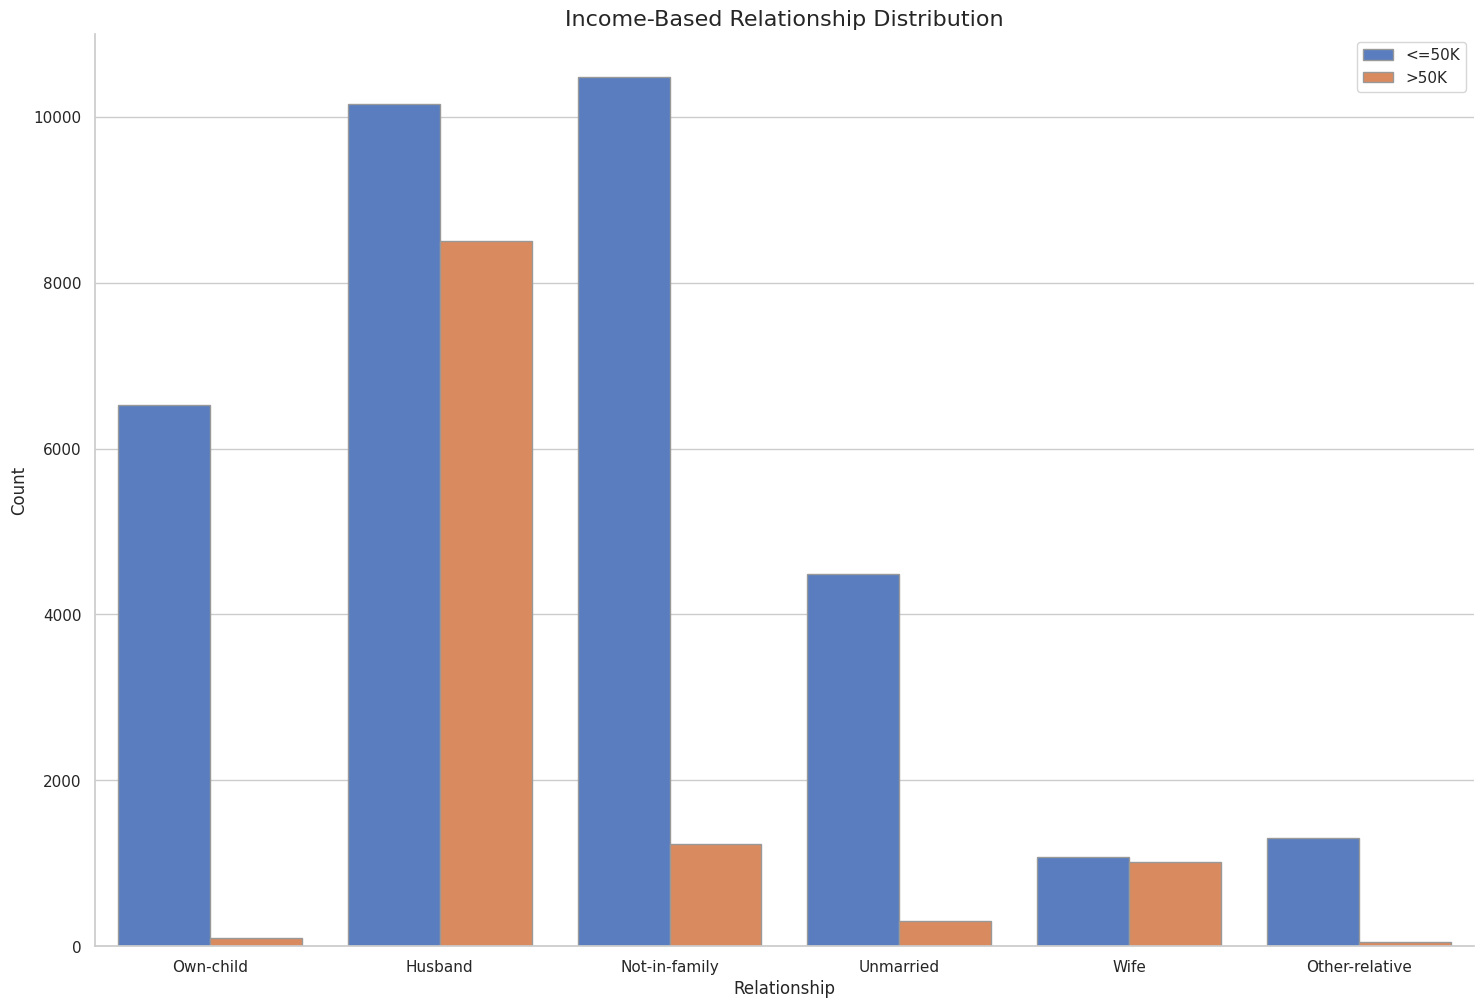

In [16]:
plot = sns.catplot(data=df, x='relationship', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=10, aspect=1.5, orient='h');
plot.set_xlabels('Relationship');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Relationship Distribution', fontsize=16);

## Race -> Income Dependency

Individual’s race

● White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black

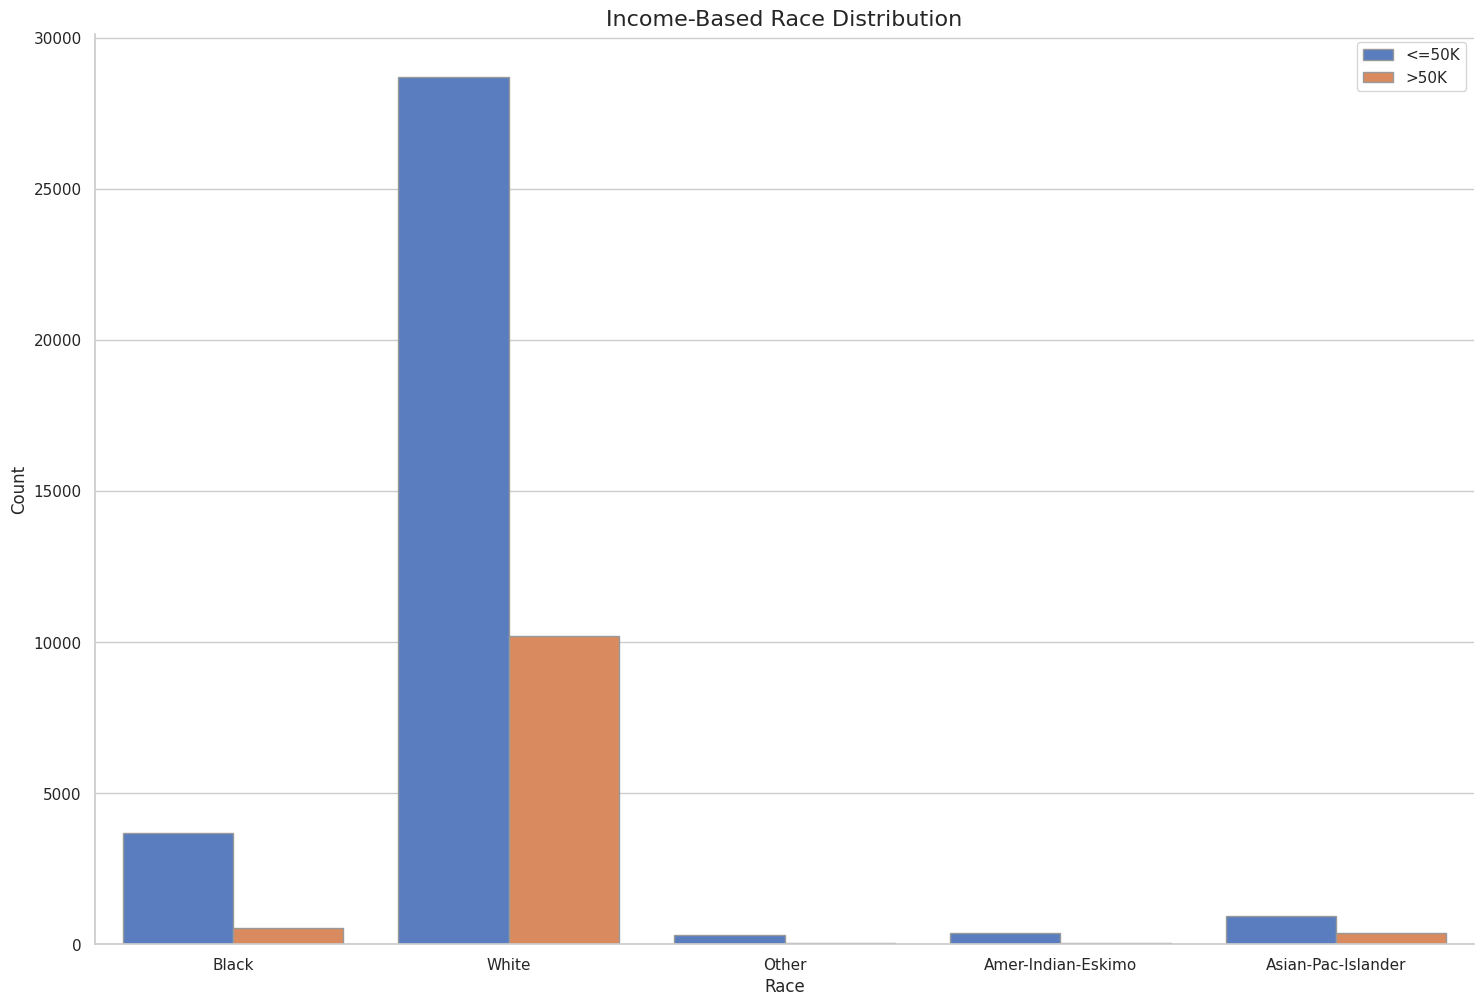

In [17]:
plot = sns.catplot(data=df, x='race', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=10, aspect=1.5, orient='h');
plot.set_xlabels('Race');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Race Distribution', fontsize=16);

## Gender -> Income Dependency

The biological sex of the individual

●  Male, Female

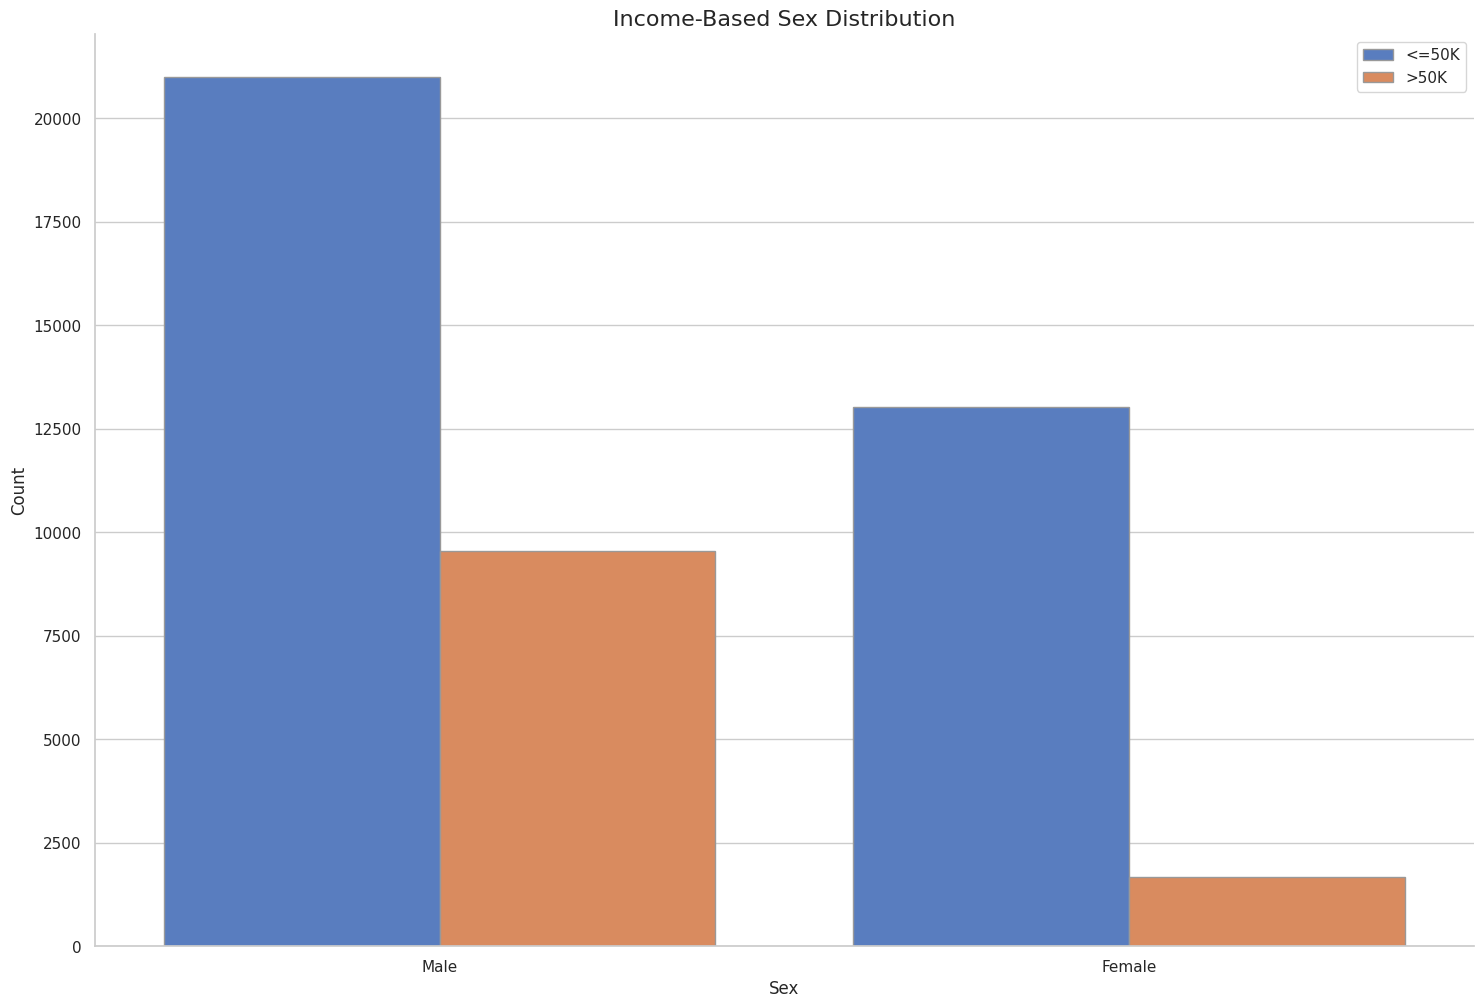

In [18]:
plot = sns.catplot(data=df, x='gender', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=10, aspect=1.5, orient='h');
plot.set_xlabels('Sex');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Sex Distribution', fontsize=16);

## Capital Gain/Loss -> Income Dependency

Capital gain and loss for an individual

● Integer greater than or equal to 0

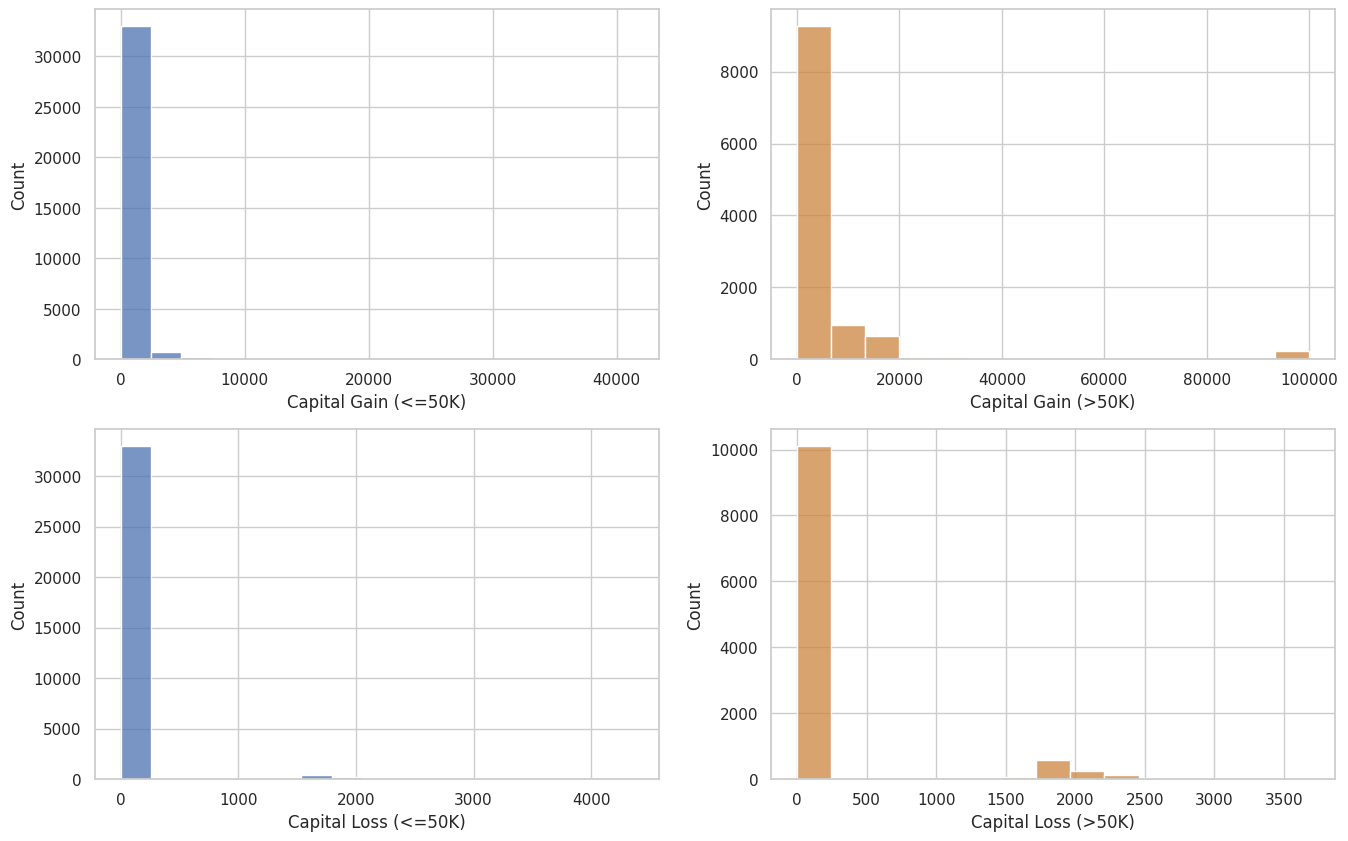

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10));
sns.histplot(data=income_less_than_50k, x='capital-gain', ax=ax[0][0]);
ax[0][0].set_xlabel('Capital Gain (<=50K)');
sns.histplot(data=income_more_than_50k, x='capital-gain', ax=ax[0][1], 
             palette='muted', color='peru');
ax[0][1].set_xlabel('Capital Gain (>50K)');

sns.histplot(data=income_less_than_50k, x='capital-loss', ax=ax[1][0]);
ax[1][0].set_xlabel('Capital Loss (<=50K)');
sns.histplot(data=income_more_than_50k, x='capital-loss', ax=ax[1][1], 
             palette='muted', color='peru');
ax[1][1].set_xlabel('Capital Loss (>50K)');

## Hours Per Week -> Income Dependency

The hours an individual has reported to work per week

●  continuous


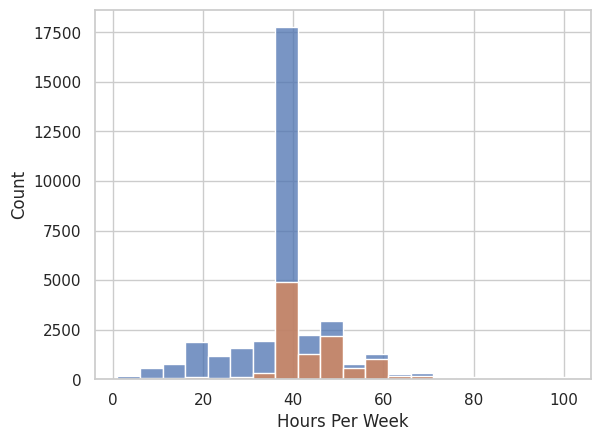

In [20]:
ax = sns.histplot(data=income_less_than_50k, x='hours-per-week', binwidth=5)
ax = sns.histplot(data=income_more_than_50k, x='hours-per-week', binwidth=5)
ax.set_xlabel('Hours Per Week');

## Native Country -> Income Dependency

Country of origin for an individual

● United-States, Cambodia, England, Puerto-Rico, Canada, Germany,
Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran,
Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal,
Ireland, France, Dominican­Republic, Laos, Ecuador, Taiwan, Haiti, Columbia,
Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El­Salvador,
Trinadad&Tobago, Peru, Hong, Holand­Netherlands

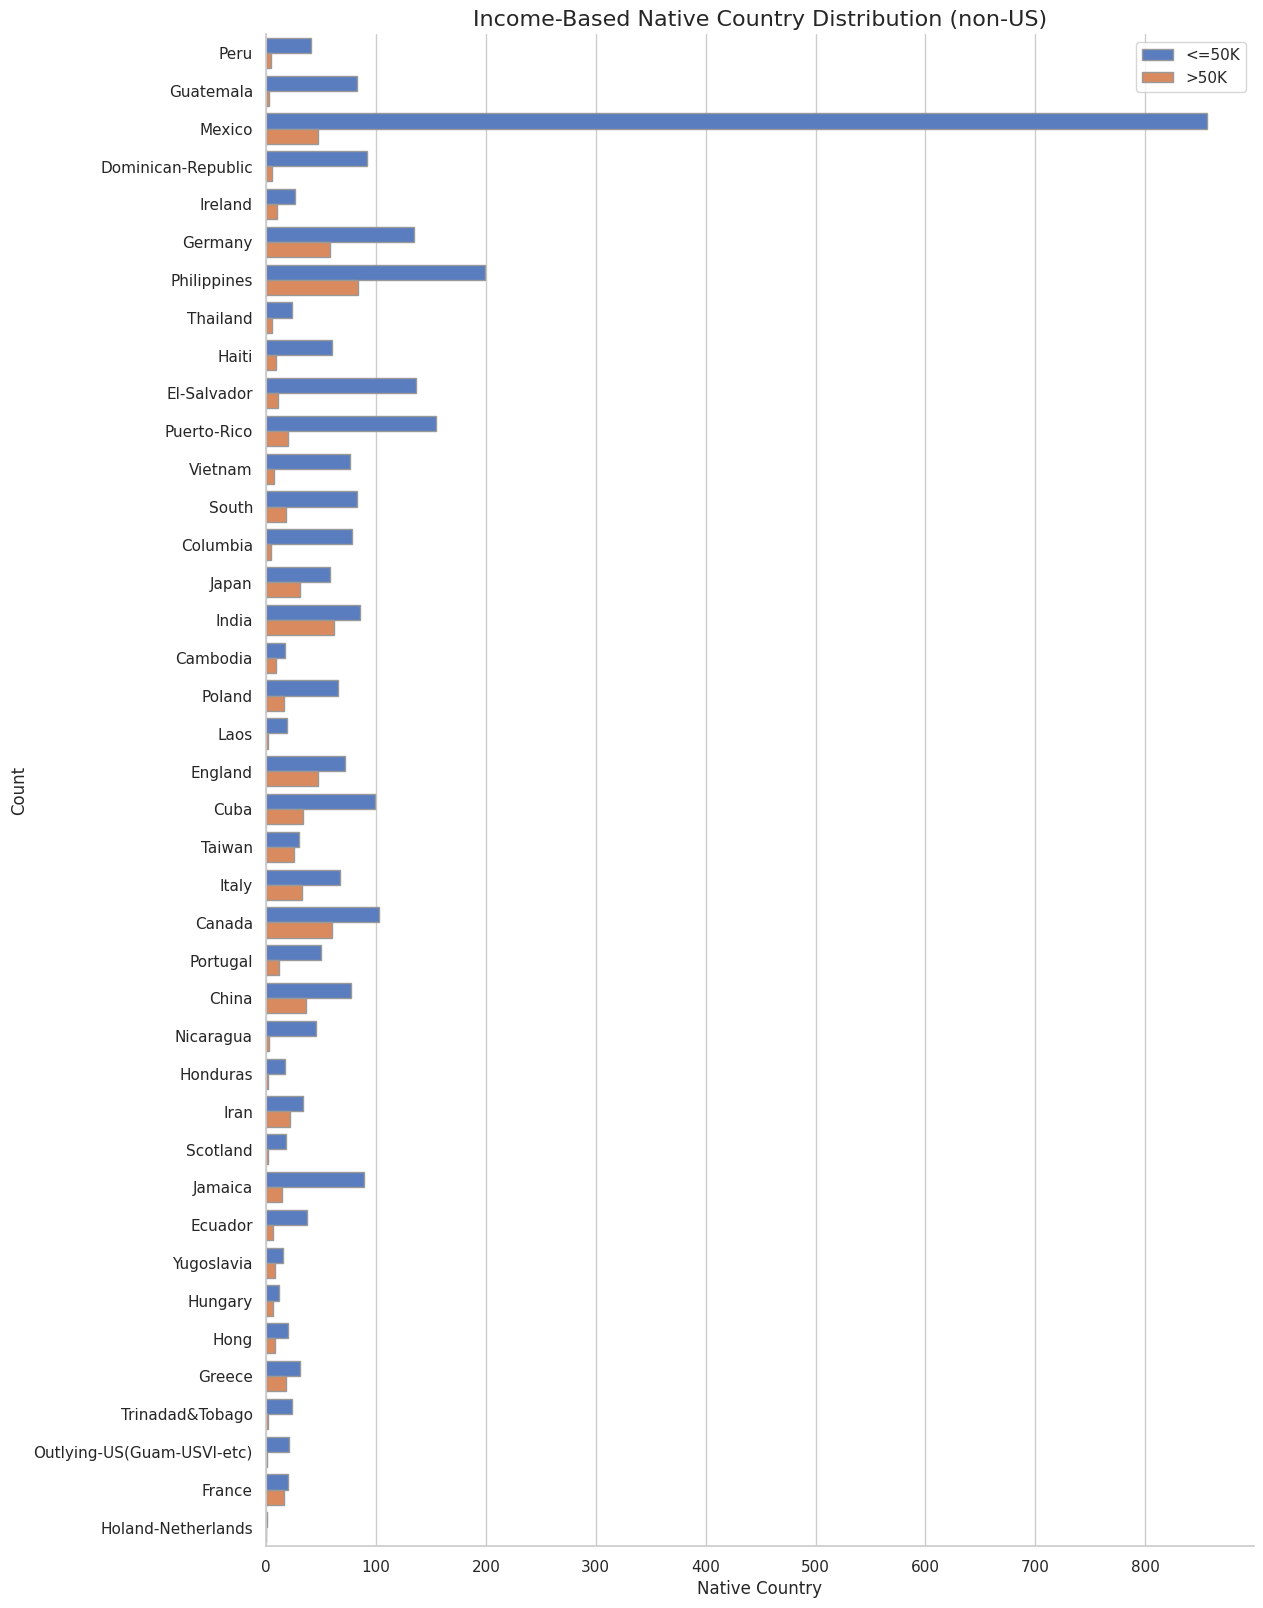

In [21]:
df.rename(columns={'native-country': 'native_country'}, inplace=True)
plot = sns.catplot(data=df.query('native_country != "United-States"'), y='native_country', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=16, aspect=.8, orient='v');
plot.set_xlabels('Native Country');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.title('Income-Based Native Country Distribution (non-US)', fontsize=16);

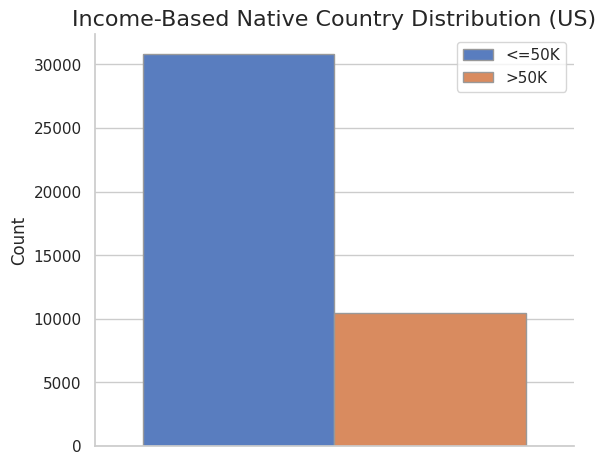

In [22]:
plot = sns.catplot(data=df.query('native_country == "United-States"'), x='native_country', hue="income", kind="count",
                   palette="muted", edgecolor=".6", legend=False,
                   height=5, aspect=1.2);
plot.set_xlabels('');
plot.set_ylabels('Count');
plt.legend(loc='upper right', labels=['<=50K', '>50K']);
plt.xticks([])
plt.title('Income-Based Native Country Distribution (US)', fontsize=16);

# Encoding

In [23]:
df = pd.concat([df, pd.get_dummies(df['gender']) \
           .replace([False, True], [0, 1])], axis=1) \
           .drop('gender', axis=1)

## Train, Val & Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), 
                                                    df['income'], test_size=0.2,
                                                    random_state=42)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                                  random_state=42)

In [26]:
cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
                'race', 'native_country']

In [27]:
def objective(trial):
    model=CatBoostClassifier(
        iterations = trial.suggest_int('iterations', 100, 300),
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
        depth = trial.suggest_int('depth', 1, 10),
        l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.2, 10),
        early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 1, 20),
        colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        loss_function=trial.suggest_categorical('loss_function', ['Logloss', 'CrossEntropy']),
        cat_features=cat_features,
        nan_mode='Min'
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )

    return accuracy_score(y_val, np.round(model.predict(X_val)))

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=150)

# best_hyperparams = study.best_params

In [28]:
catboost_params = {'iterations': 300, 'learning_rate': 0.23349393130797275, 'depth': 3,
                   'l2_leaf_reg': 1.0548787051558548, 'early_stopping_rounds': 19,
                   'colsample_bylevel': 0.8741852150877386, 'loss_function': 'Logloss'}

In [29]:
model = CatBoostClassifier(**catboost_params)
model.fit(X_train, y_train, verbose=False, cat_features=cat_features)
prediction = model.predict(X_test)

In [30]:
accuracy_score(prediction, y_test)

0.8734107241569928